In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, precision_score, confusion_matrix, accuracy_score, f1_score, auc, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler


In [ ]:
cols = ['NoOfTimes','Concentration', 'BloodPressure', 'Skinfold', 'Serum', 'BodyMass', 'Diabetes', 'Age']
data = pd.read_csv("veri-seti.txt" , delimiter='\t', names=['NoOfTimes','Concentration', 'BloodPressure', 'Skinfold', 'Serum', 'BodyMass', 'Diabetes', 'Age', 'Output'])
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop('Output', axis=1)), columns=cols)

pca = PCA(n_components=8)
data_pca = pca.fit_transform(data_scaled)

lda = LDA(n_components=1)
data_lda = lda.fit_transform(data_scaled, data['Output'])

top_two_pca_eigenvalues = pca.explained_variance_ratio_[:2]
top_two_lda_eigenvalues = lda.explained_variance_ratio_[:2]

print("Top two eigenvalues for PCA:", top_two_pca_eigenvalues)
print("Top two eigenvalues for LDA:", top_two_lda_eigenvalues)

# Get the feature contributions for PCA
pca_features = pd.DataFrame(pca.components_, columns=cols)
pca_features_abs = pca_features.abs().sum(axis=1)
print("Feature contributions for PCA:")
print(pca_features_abs)

# Get the feature coefficients for LDA
lda_features = pd.DataFrame(lda.scalings_.T, columns=cols)
lda_features_abs = lda_features.abs().sum(axis=1)
print("\nFeature coefficients for LDA:")
print(lda_features_abs)

Top two eigenvalues for PCA: [0.31192249 0.21186663]
Top two eigenvalues for LDA: [1.]
Feature contributions for PCA:
0    1.927522
1    2.543855
2    2.402327
3    2.393336
4    2.032861
5    2.552970
6    2.105794
7    2.058016
dtype: float64

Feature coefficients for LDA:
0    15.368307
dtype: float64


PCA Matrix:
 [[127  24]
 [ 35  45]]
Accuracy: 0.7445887445887446
F1 Score: 0.6040268456375839
Sensitivity: 0.5625
Specificity: 0.8410596026490066


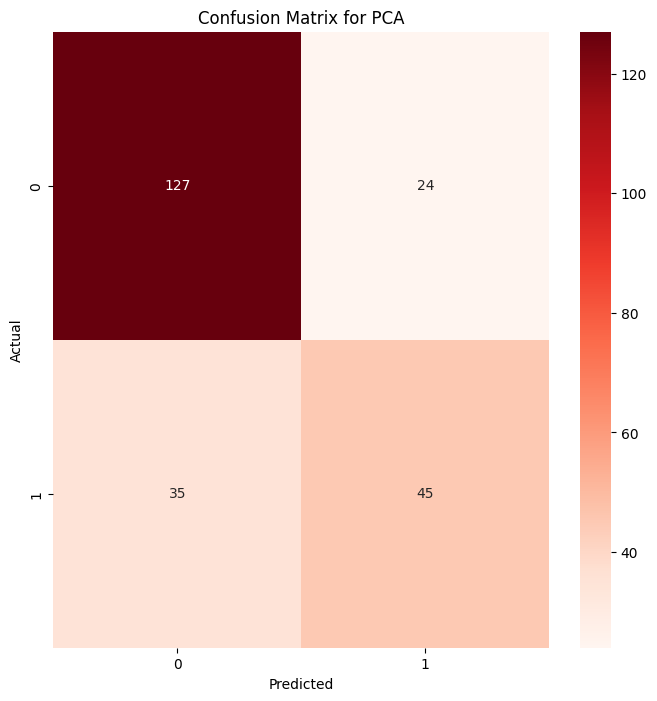

LDA Matrix:
 [[120  31]
 [ 31  49]]
Accuracy: 0.7316017316017316
F1 Score: 0.6125
Sensitivity: 0.6125
Specificity: 0.7947019867549668


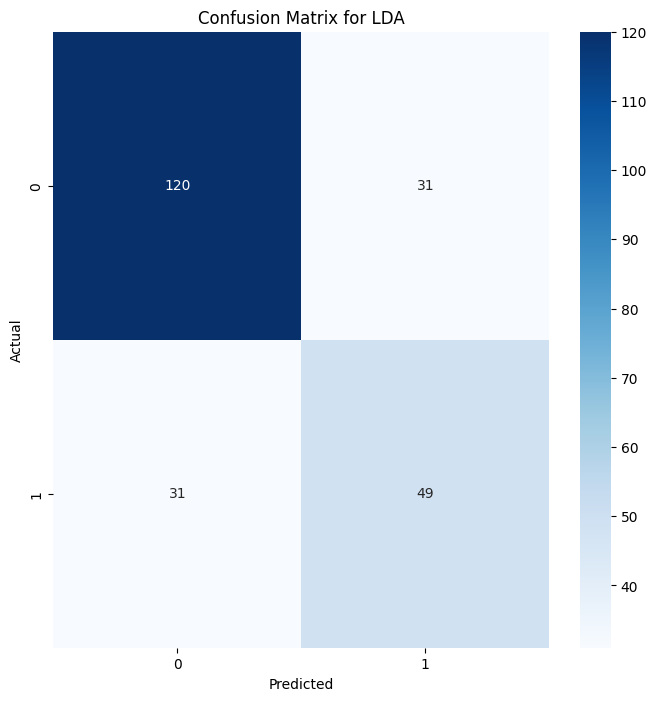

In [ ]:
def train_lda_model(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_scaled, y_train)
    return lda, scaler

def train_model(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, title='PCA Model Evaluation'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


    return cm, accuracy, f1, sensitivity, specificity

def evaluate_lda_model(lda_model, scaler, X_test, y_test, title='LDA Model Evaluation'):
    X_test_scaled = scaler.transform(X_test)
    y_pred = lda_model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) != 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0

    return cm, accuracy, f1, sensitivity, specificity


X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(data_scaled, data['Output'], test_size=0.3, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, data['Output'], test_size=0.3, random_state=42)

lda_model_original, scaler_original = train_lda_model(X_train_original, y_train_original)
lda_model_lda, scaler_lda = train_lda_model(X_train_pca, y_train_pca)

model_original = train_model(X_train_original, y_train_original)
model_pca = train_model(X_train_pca, y_train_pca)

cm_pca_metrics, accuracy_pca_metrics, f1_pca_metrics, sensitivity_pca, specificity_pca = evaluate_model(model_pca, X_test_pca, y_test_pca, title='PCA Evaluation')
cm_lda_metrics, accuracy_lda_metrics, f1_lda_metrics, sensitivity_lda, specificity_lda = evaluate_lda_model(lda_model_lda, scaler_lda, X_test_pca, y_test_pca, title='LDA Evaluation')

print("PCA Matrix:\n", cm_pca_metrics)
print("Accuracy:", accuracy_pca_metrics)
print("F1 Score:", f1_pca_metrics)
print("Sensitivity:", sensitivity_pca)
print("Specificity:", specificity_pca)

plt.figure(figsize=(8, 8))
sns.heatmap(cm_pca_metrics, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for PCA')
plt.show()

print("LDA Matrix:\n", cm_lda_metrics)
print("Accuracy:", accuracy_lda_metrics)
print("F1 Score:", f1_lda_metrics)
print("Sensitivity:", sensitivity_lda)
print("Specificity:", specificity_lda)

plt.figure(figsize=(8, 8))
sns.heatmap(cm_lda_metrics, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LDA')
plt.show()



Multiple Linear Regression Coefficients:
NoOfTimes: 0.3076460629927154
Concentration: 1.1744584285172246
BloodPressure: -0.20713761704132405
Skinfold: 0.0006735745639103174
Serum: -0.15219404760691996
BodyMass: 0.9187233902933907
Diabetes: 0.4964805961556298
Age: 0.20558936994154053

Multinomial Logistic Regression Coefficients:
NoOfTimes: 0.3076460629927154
Concentration: 1.1744584285172246
BloodPressure: -0.20713761704132405
Skinfold: 0.0006735745639103174
Serum: -0.15219404760691996
BodyMass: 0.9187233902933907
Diabetes: 0.4964805961556298
Age: 0.20558936994154053
Accuracy Linear: 0.7489177489177489
Precision Linear 0.6716417910447762
Recall Linear 0.5555555555555556
Accuracy Logistic: 0.7445887445887446
Precision Logistic: 0.671875
Recall Logistic 0.5308641975308642


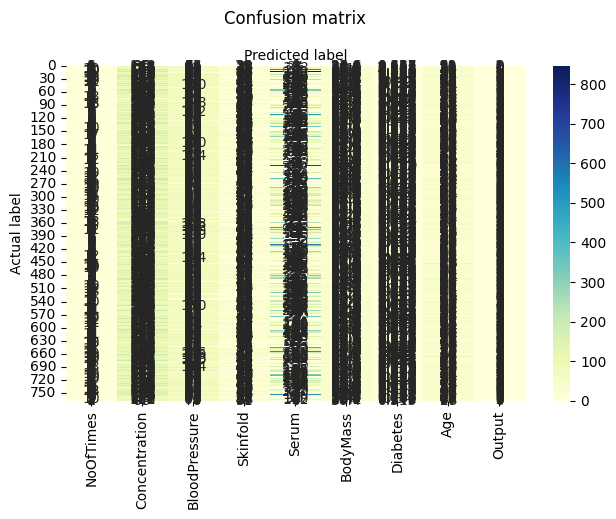

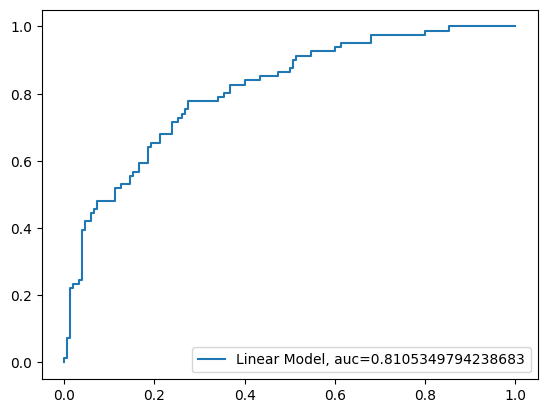

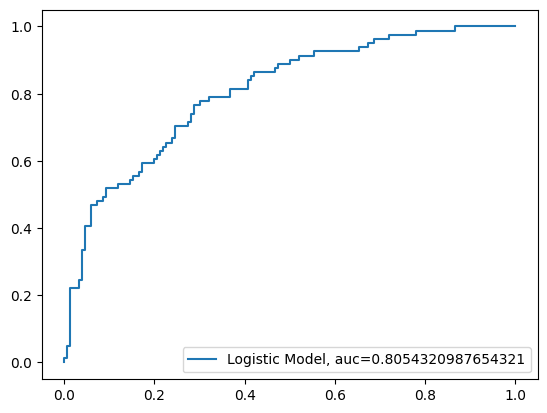

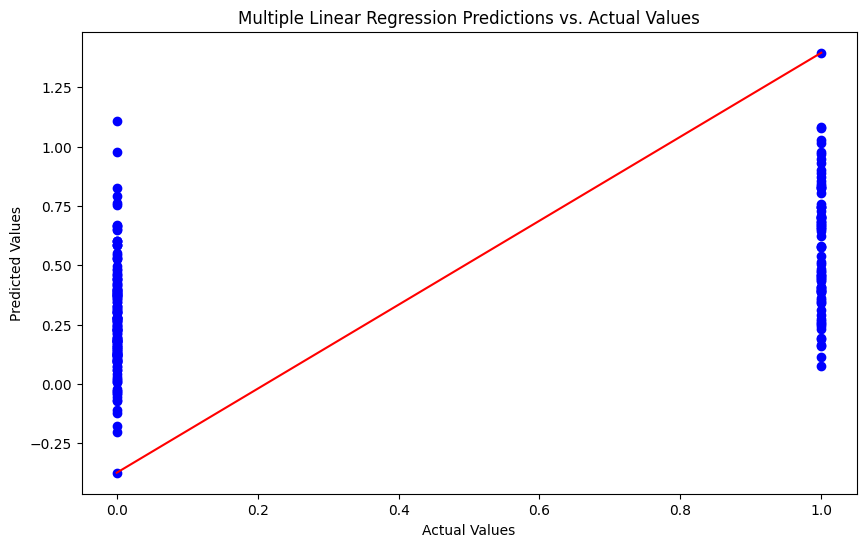

In [ ]:
def train_linear_regression(X_train, y_train):
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    return linear_model

def train_logistic_regression(X_train, y_train):
    logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logistic_model.fit(X_train, y_train)
    return logistic_model

def print_coefficients(model, columns):
    for idx, col_name in enumerate(data_scaled.columns):
      print(f"{col_name}: {linear_model.coef_[idx]}")


def evaluate_linear_regression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

def evaluate_logistic_regression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def pridection(y_pred_linear):
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred_linear, color='blue')
  plt.plot([min(y_test), max(y_test)], [min(y_pred_linear), max(y_pred_linear)], color='red')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Multiple Linear Regression Predictions vs. Actual Values')
  plt.show()


X_train, X_test, y_train, y_test = train_test_split(data_scaled, data['Output'], test_size=0.3, random_state=100)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
y_pred = (linear_model.predict(X_test) > 0.5).astype(int)

linear_model = train_linear_regression(X_train, y_train)
logistic_model = train_logistic_regression(X_train, y_train)
y_pred_regression = logistic_model.predict(X_test)

print("Multiple Linear Regression Coefficients:")
print_coefficients(linear_model, data_scaled.columns)

print("\nMultinomial Logistic Regression Coefficients:")
print_coefficients(logistic_model, data_scaled.columns)

mse_linear, r2_linear = evaluate_linear_regression(linear_model, X_test, y_test)
accuracy_logistic = evaluate_logistic_regression(logistic_model, X_test, y_test)

print("Accuracy Linear:", accuracy_score(y_test, y_pred))
print("Precision Linear", precision_score(y_test, y_pred))
print("Recall Linear",recall_score(y_test, y_pred))


print("Accuracy Logistic:", accuracy_score(y_test, y_pred_regression))
print("Precision Logistic:", precision_score(y_test, y_pred_regression))
print("Recall Logistic",recall_score(y_test, y_pred_regression))

plt.figure()
y_pred_proba1 = linear_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba1)
auc = roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr,tpr,label="Linear Model, auc="+str(auc))
plt.legend(loc=4)
plt.show()

plt.figure()
y_pred_proba = logistic_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Model, auc="+str(auc))
plt.legend(loc=4)
plt.show()

pridection(y_pred_linear)

In [ ]:
def train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    tree_classifier = DecisionTreeClassifier()
    tree_classifier.fit(X_train, y_train)
    tree_predictions = tree_classifier.predict(X_test)

    tree_accuracy = accuracy_score(y_test, tree_predictions)
    tree_classification_report = classification_report(y_test, tree_predictions)
    tree_confusion_matrix = confusion_matrix(y_test, tree_predictions)

    print("\nConfusion Matrix:")
    print(tree_confusion_matrix)
    print("\nClassification Report:")
    print(tree_classification_report)
    print(f"Accuracy: {tree_accuracy}")

train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test)



Confusion Matrix:
[[110  40]
 [ 39  42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       150
           1       0.51      0.52      0.52        81

    accuracy                           0.66       231
   macro avg       0.63      0.63      0.63       231
weighted avg       0.66      0.66      0.66       231

Accuracy: 0.658008658008658


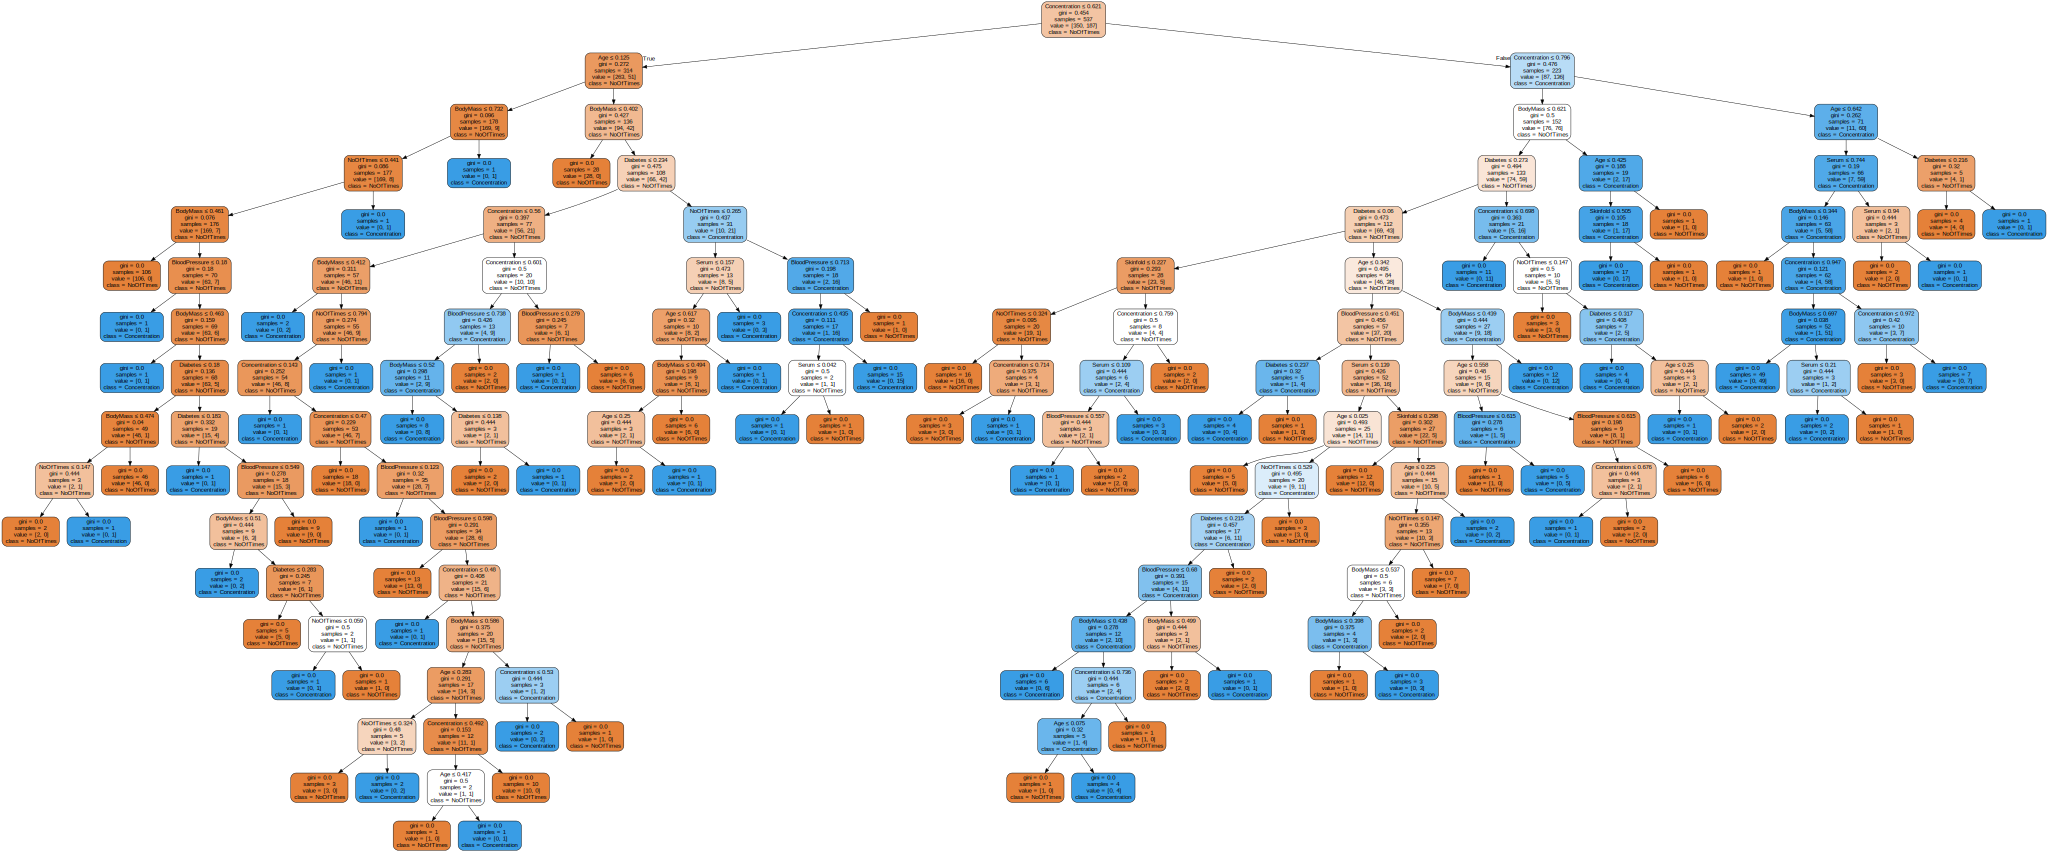

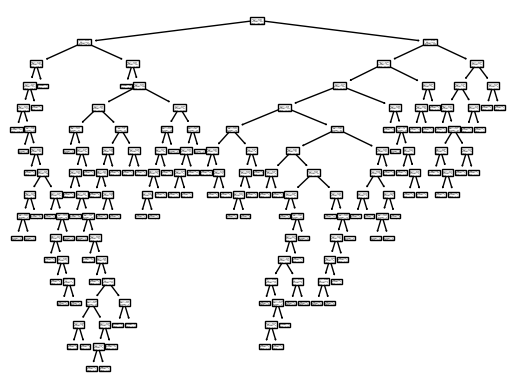

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("Decession Tree")
dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names= cols,
                      class_names= cols,
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

Accuracy: 0.7229437229437229
F1 Score: 0.5949367088607596

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       150
           1       0.61      0.58      0.59        81

    accuracy                           0.72       231
   macro avg       0.69      0.69      0.69       231
weighted avg       0.72      0.72      0.72       231


Confusion Matrix:
[[120  30]
 [ 34  47]]


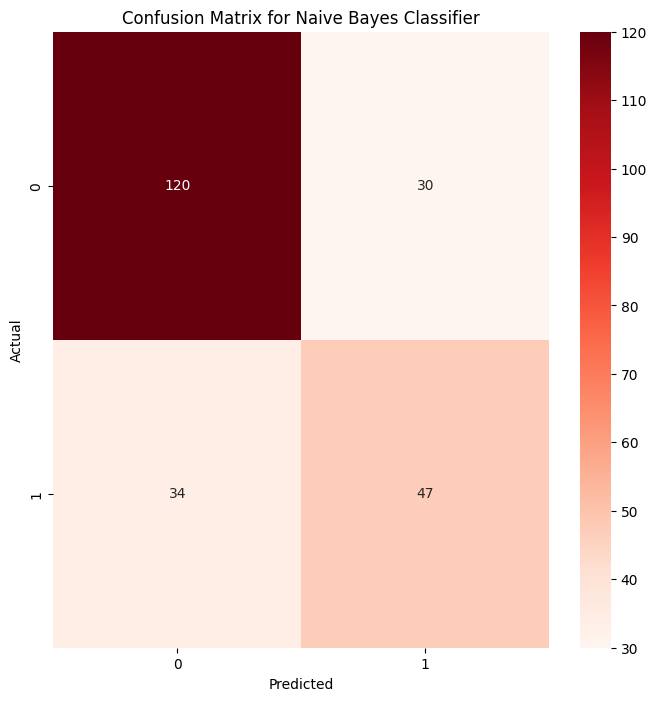

In [ ]:
def train_and_evaluate_naive_bayes(X_train, y_train, X_test, y_test):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    nb_predictions = nb_classifier.predict(X_test)

    nb_accuracy = accuracy_score(y_test, nb_predictions)
    nb_f1 = f1_score(y_test, nb_predictions)
    nb_classification_report = classification_report(y_test, nb_predictions)
    nb_confusion_matrix = confusion_matrix(y_test, nb_predictions)

    print(f"Accuracy: {nb_accuracy}")
    print(f"F1 Score: {nb_f1}")
    print("\nClassification Report:")
    print(nb_classification_report)
    print("\nConfusion Matrix:")
    print(nb_confusion_matrix)

    plt.figure(figsize=(8, 8))
    sns.heatmap(nb_confusion_matrix, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Naive Bayes Classifier')
    plt.show()


train_and_evaluate_naive_bayes(X_train, y_train, X_test, y_test)


